In [1]:
import gurobipy as gp
from gurobipy import GRB

In [2]:
import networkx as nx

In [3]:
# Add fixed vertices as coordinate tuples
# Add variable vertices as strings

instance = nx.Graph()
#instance.add_edge((0,0), (0,1))
#instance.add_edge((0,0), (1,0))
instance.add_edge((0,0), "A")
instance.add_edge((0,1), "A")
instance.add_edge("A", "B")
instance.add_edge((2,2), "C")
instance.add_edge("C", "B")
instance.add_edge((2,0), "C")
variable_nodes = [n for n in instance.nodes if not isinstance(n, tuple)]

In [4]:
model = gp.Model("playground")

# positions of variable nodes
x_pos = model.addVars(variable_nodes, name="x", lb=-GRB.INFINITY, ub=GRB.INFINITY,
                   vtype=GRB.CONTINUOUS)
y_pos = model.addVars(variable_nodes, name="y", lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
# squared edge length
squared_e_length = model.addVars(instance.edges, name="e", vtype=GRB.CONTINUOUS)
# eddge length differences
e_hori = model.addVars(instance.edges, name="s",lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
e_verti = model.addVars(instance.edges, name="w", lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
# power of a vertex
power = model.addVars(instance.nodes, name="v", lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)


for vw in instance.edges:
    # squared edge length via second order cone constraint
    model.addQConstr(squared_e_length[vw]>= e_hori[vw]*e_hori[vw] + e_verti[vw]*e_verti[vw])
    def get_x(n):
        if isinstance(n, tuple):
            return n[0]
        else:
            return x_pos[n]
    def get_y(n):
        if isinstance(n, tuple):
            return n[1]
        else:
            return y_pos[n]
    model.addConstr(e_hori[vw]  == get_x(vw[0]) - get_x(vw[1]))
    model.addConstr(e_verti[vw] == get_y(vw[0]) - get_y(vw[1]))
# enforce power of a vertex to be at least the squared length of the longest edge
for n in instance.nodes:
    for vw in instance.edges(n):
        # the edge may be inverted
        if vw in squared_e_length:
            model.addConstr(power[n] >= squared_e_length[vw])
        else:
            model.addConstr(power[n] >= squared_e_length[vw[::-1]])

    
model.setObjective(gp.quicksum(power[n] for n in instance.nodes), GRB.MINIMIZE)
model.optimize()

var_node_positions = {n: (x_pos[n].x, y_pos[n].x) for n in variable_nodes}
print("Objective value:", model.objVal)
print("Variable node positions:")
for n in variable_nodes:
    print(n, x_pos[n].x, y_pos[n].x)
print("Power of vertices:")
for n in instance.nodes:
    print(n, power[n].x**0.5)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: AMD Ryzen 7 5700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24 rows, 31 columns and 52 nonzeros
Model fingerprint: 0x437c67b2
Model has 6 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 8 rows and 8 columns
Presolve time: 0.01s
Presolved: 28 rows, 35 columns, 60 nonzeros
Presolved model has 6 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 6.900e+01
 Factor NZ  : 2.500e+02
 Factor Ops : 2.722e+03 (less than 1 second per iteration)
 Threads    : 1

    

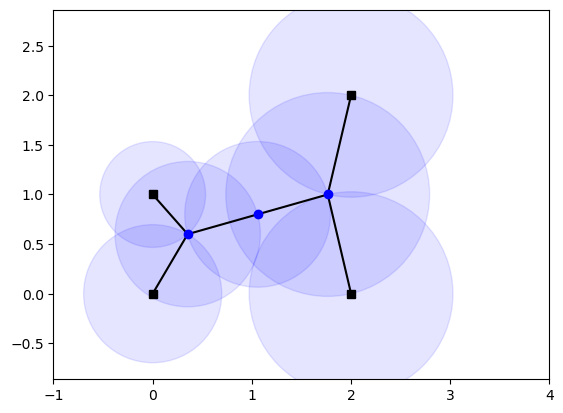

In [18]:
import matplotlib.pyplot as plt

solution = nx.Graph()
for vw in instance.edges:
    def get_pos(n):
        if isinstance(n, tuple):
            return n
        else:
            return var_node_positions[n]
    solution.add_edge(get_pos(vw[0]), get_pos(vw[1]))
plt.figure()
for vw in solution.edges:
    plt.plot([vw[0][0], vw[1][0]], [vw[0][1], vw[1][1]], 'k-')
# plot vertices
for n in solution.nodes:
    if n in instance.nodes:
        plt.plot(n[0], n[1], 'ks')
    else:
        plt.plot(n[0], n[1], 'o', color="blue")
    # draw circle of power assignment
for n in instance.nodes:
    plt.gca().add_artist(plt.Circle(get_pos(n), power[n].x**0.5, color='blue', fill=True, alpha=0.1))
# uniform axis scaling
plt.axis('equal')
plt.xlim(-1, 4)
plt.ylim(-2, 4)
plt.savefig("../docs/figures/example.png")
plt.show()